# Dimensionality Reduction - PCA

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
import mpld3

In [2]:
import neuralyzer

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None
plt.rcParams['figure.figsize'] = (8,8)

In [4]:
datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
#datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1.tif'
#datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-16 21:29:05 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-16 21:29:05 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-16 21:29:05 ] [ data_handler ] [ DEBUG ] : root_path set to /Users/michael/coding/RIKEN/lib/neuralyzer/notebooks/dev
[ 2015-04-16 21:29:05 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_testdata.tif.hdf5


In [5]:
d = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).T

In [6]:
d = d.astype('float')

In [7]:
d.shape

(65536, 1000)

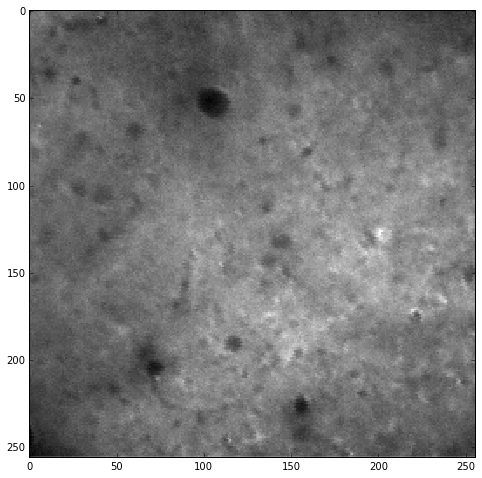

In [8]:
plt.imshow(d.mean(axis=1).reshape(256,256))

In [9]:
d.shape

(65536, 1000)

### Mean Subtraction

In [10]:
dmean = d.mean(axis=1)
d = d - np.tile(dmean, (d.shape[1],1)).T

## Principal Component Analysis

In [11]:
from sklearn.decomposition import IncrementalPCA

In [20]:
pca = IncrementalPCA()

In [22]:
%prun pca.fit(d.T)

In [23]:
%prun dpca = pca.transform(d.T)

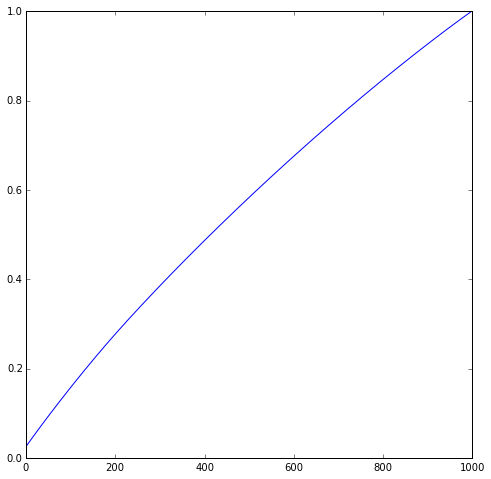

In [38]:
plt.plot(pca.explained_variance_ratio_[:].cumsum())

In [45]:
pca.components_.shape

(1000, 65536)

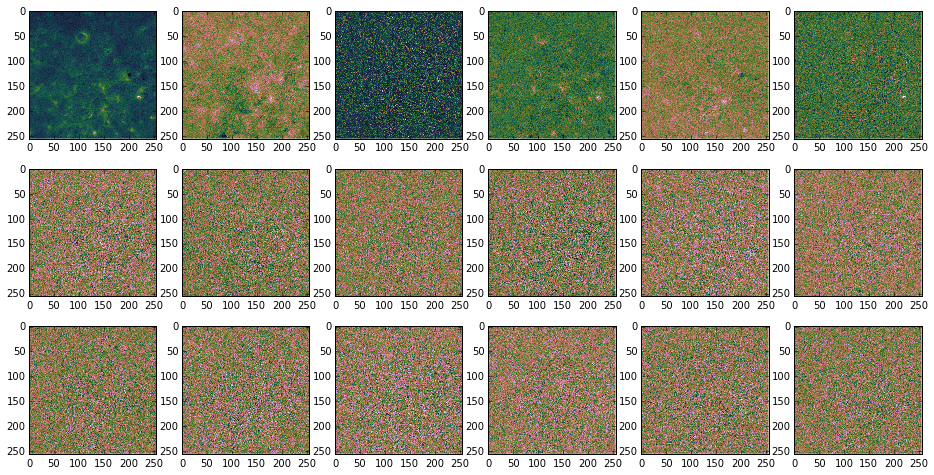

In [22]:
fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(16, 8))
for i in range(18):
    ax[int(i/6)][np.mod(i,6)].imshow(pca.components_[i,:].reshape(256,256), cmap='cubehelix')

In [23]:
dpca.shape

(1000, 1000)

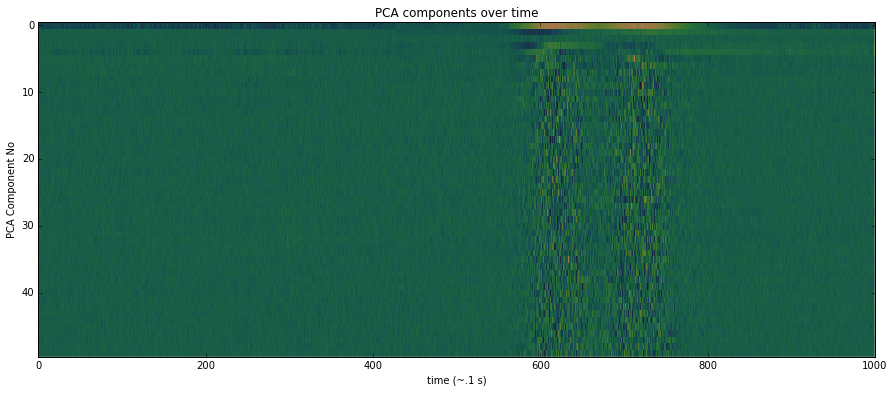

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(dpca.T[:50,:], cmap='cubehelix', aspect=8)
ax.set_title('PCA components over time')
ax.set_ylabel('PCA Component No')
ax.set_xlabel('time (~.1 s)')

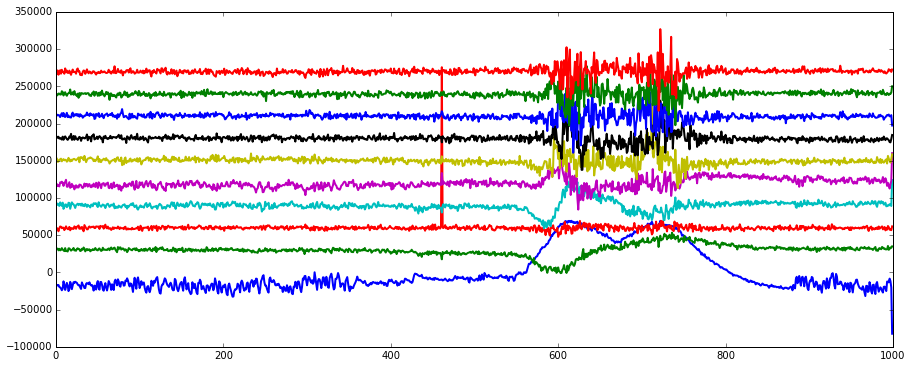

In [30]:
fig, ax = plt.subplots(figsize=(15,6))
for i in range(0, 10):
    ax.plot(dpca[:,i]+30000*i, lw=2)

In [25]:
from mpl_toolkits.mplot3d import Axes3D

In [32]:
plt.colorbar?

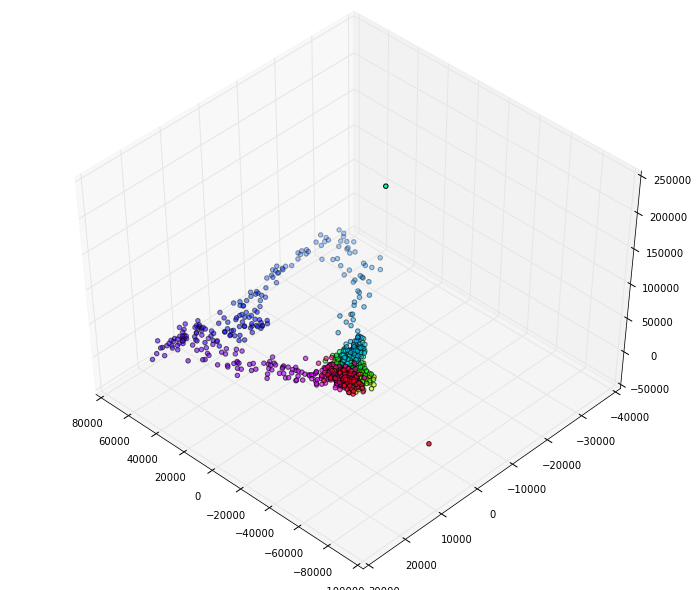

In [34]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(dpca[:,0], dpca[:,1], dpca[:,2], c=np.array(range(dpca.shape[0])), cmap='hsv')

In [93]:
dpca[:,0].shape

(500,)

### Running the large Dataset !!

In [4]:
from sklearn.decomposition import PCA, IncrementalPCA

In [5]:
datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-16 13:15:29 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-16 13:15:29 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-16 13:15:29 ] [ data_handler ] [ DEBUG ] : root_path set to /home/michael/lib/neuralyzer/notebooks/dev
[ 2015-04-16 13:15:55 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /home/michael/datac/140316/data5/data2/Image_0001_0001_channel1.tif.hdf5


In [6]:
d = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).T
dmean = d.mean(axis=1)
d = d - np.tile(dmean, (d.shape[1],1)).T
d.shape

(262144, 18000)

### Creating a memmap

In [12]:
d = d.T
dshape = d.shape
ddtype = d.dtype

In [13]:
memmapfile, _ = os.path.splitext(datafile)
memmapfile += '_memmap.dat'
dmm = np.memmap(memmapfile, dtype=ddtype, shape=dshape, mode='w+')
dmm[:] = d[:]
del dmm, d

In [14]:
dmm = np.memmap(memmapfile, dtype=ddtype, shape=dshape, mode='r')

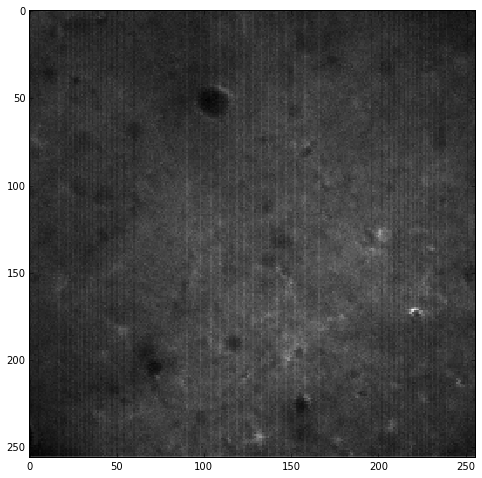

In [16]:
dmm.mean(axis=0).reshape(256,256)
plt.imshow(dmm.var(axis=0).reshape(256,256))

#### do IncrementalPCA on memmap d

In [17]:
dmm = np.memmap(memmapfile, dtype=ddtype, shape=dshape, mode='r')

In [18]:
dmm.mean(axis=0)

memmap([ -5.96628524e-13,   1.80534698e-13,  -2.78760126e-13, ...,
        -4.82714313e-13,   4.32237357e-13,   3.23780114e-13])

In [19]:
pca = IncrementalPCA()

In [20]:
%prun pca.fit(dmm)

In [21]:
%prun dpca = pca.transform(dmm)

In [ ]:
import datetime
print datetime.datetime.now()